In [72]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import xgboost as xgb
import regex as re

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import ModelCheckpoint, EarlyStopping
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV

%matplotlib inline

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


# Loading Dataset

In [73]:
stock_exchange_mk = pd.read_csv('data_mse_mse_historic_data_active.csv', sep='\t', parse_dates=['Date'])

In [74]:
df = pd.DataFrame(stock_exchange_mk)
df["stock_id"] = df["stock_id"].astype('category')
df.columns = df.columns.str.lower()

# Missing Dates

In [75]:
stocks = df.stock_id.unique()
dates_all = pd.period_range(min(df.date), max(df.date)).to_timestamp()
idx = pd.MultiIndex.from_product((dates_all, stocks), names=['date', 'stock_id'])
df_new = df.set_index(['date', 'stock_id']).reindex(idx).reset_index()

### Drop Unnecessary Dates

In [76]:
df_list = []
for stock in df.stock_id.unique():
    each_df = df[df.stock_id == stock]
    groupby_stock = each_df.groupby([pd.PeriodIndex(data=each_df.date, freq='D'), 'stock_id'])
    df_list.append(groupby_stock)

In [77]:
stock_name = []
stock_start_date = []
for i in df_list:
    name = min(i.date)[0][1]
    stock_name.append(name)
    date = min(i.date)[0][0]
    stock_start_date.append(date)
    
start_date = dict(zip(stock_name, stock_start_date))

In [78]:
start_date_df = pd.DataFrame.from_dict(start_date, orient='index', dtype='datetime64[ns]', columns=['start_date'])

In [79]:
start_date_df.head()

,start_date
ALK,1997-01-09
BESK,2002-10-10
FERS,1999-04-15
GRNT,1999-10-28
KMB,1997-05-15


In [80]:
df_clean = df_new.set_index('stock_id').join(start_date_df, lsuffix='_filter', on='stock_id').reset_index()

In [81]:
df_clean.head()

,stock_id,date,open,high,low,close,volume,adj close,quantity,average,change %,volume total,ratio,ratio 1m,ratio 3m,ratio 6m,ratio 1y,ratio 2y,ratio 3y,start_date
0,ALK,1997-01-09,1070.0,1070.0,1070.0,1070.0,279270.0,1070.0,261.0,1070.0,NaN,279270.0,0.077,0.085,0.085,0.082,0.08,0.08,0.08,1997-01-09
1,BESK,1997-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002-10-10
2,FERS,1997-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-04-15
3,GRNT,1997-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-10-28
4,KMB,1997-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-05-15


In [82]:
print(df_clean.shape, df_new.shape, df.shape)

(189860, 20) (189860, 19) (43441, 19)


In [83]:
df_drop = df_clean[df_clean['date'] >= df_clean['start_date']]

In [84]:
min(df_drop.date[df_drop.stock_id == 'BESK'])

Timestamp('2002-10-10 00:00:00')

### Filling NaN Values

In [85]:
df_sorted = df_drop.sort_values(by=['stock_id', 'date'], ascending=True)
test = df_sorted.drop_duplicates()
print(df_sorted.shape, test.shape)

(164754, 20) (164754, 20)


In [86]:
df_sorted.head()

,stock_id,date,open,high,low,close,volume,adj close,quantity,average,change %,volume total,ratio,ratio 1m,ratio 3m,ratio 6m,ratio 1y,ratio 2y,ratio 3y,start_date
0,ALK,1997-01-09,1070.0,1070.0,1070.0,1070.0,279270.0,1070.0,261.0,1070.0,NaN,279270.0,0.077,0.085,0.085,0.082,0.08,0.08,0.08,1997-01-09
22,ALK,1997-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
44,ALK,1997-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
66,ALK,1997-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
88,ALK,1997-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09


In [87]:
column_average = df_sorted['average']
df_sorted.drop('average', axis=1, inplace=True)
df_sorted.insert(5, 'average', column_average)

In [88]:
df_sorted

,stock_id,date,open,high,low,average,close,volume,adj close,quantity,change %,volume total,ratio,ratio 1m,ratio 3m,ratio 6m,ratio 1y,ratio 2y,ratio 3y,start_date
0,ALK,1997-01-09,1070.0,1070.0,1070.0,1070.00,1070.0,279270.0,1070.0,261.0,NaN,279270.0,0.077,0.085,0.085,0.082,0.080,0.080,0.080,1997-01-09
22,ALK,1997-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
44,ALK,1997-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
66,ALK,1997-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
88,ALK,1997-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
110,ALK,1997-01-14,1070.0,1070.0,1050.0,1059.86,1050.0,378370.0,1050.0,357.0,1.0,378370.0,0.076,0.084,0.084,0.081,0.080,0.080,0.080,1997-01-09
132,ALK,1997-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
154,ALK,1997-01-16,1050.0,1030.0,1030.0,1030.00,1030.0,246170.0,1030.0,239.0,3.0,246170.0,0.074,0.082,0.082,0.079,0.077,0.077,0.077,1997-01-09
176,ALK,1997-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09
198,ALK,1997-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-01-09


In [89]:
# average will be equal to close price because there is no transactions on Nan 
# open, high, low are fulfil with close price because there is no transaction next day
df_sorted[['open', 'high', 'low', 'average', 
           'close']] = df_sorted[['open', 'high', 'low', 'average', 
                                  'close']].assign(close=df_sorted['close'].ffill()).bfill(axis=1)

# quantity, volume and volume total should be 0 also because of no transactions
df_sorted[['volume', 'quantity', 'volume total', 
           'change %']] = df_sorted[['volume', 'quantity', 'volume total', 'change %']].fillna(0)

# drop adj close same as close
df_sorted = df_sorted.drop('adj close', axis=1)

In [90]:
df_sorted = df_sorted[df_sorted.columns.drop(list(df_sorted.filter(regex='ratio')))]

In [91]:
df_sorted.head()

,stock_id,date,open,high,low,average,close,volume,quantity,change %,volume total,start_date
0,ALK,1997-01-09,1070.0,1070.0,1070.0,1070.0,1070.0,279270.0,261.0,0.0,279270.0,1997-01-09
22,ALK,1997-01-10,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
44,ALK,1997-01-11,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
66,ALK,1997-01-12,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
88,ALK,1997-01-13,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09


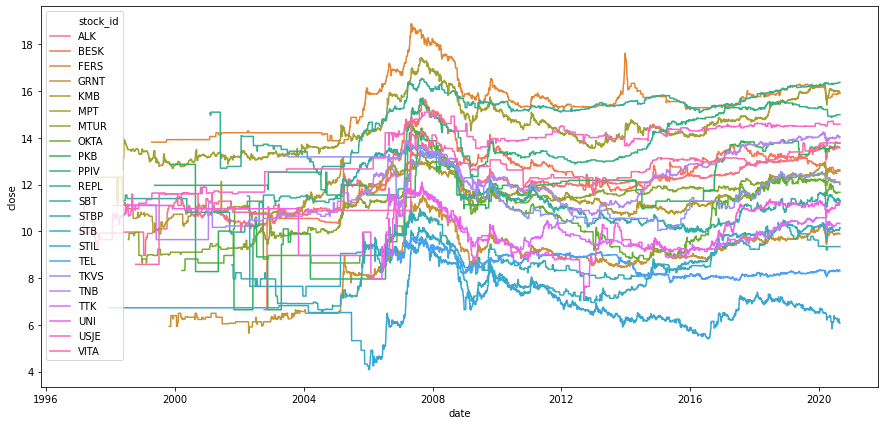

In [92]:
plt.figure(figsize=(15,7))
sns.lineplot(x="date", y=np.log2(df_sorted.close), hue="stock_id", data=df_sorted)
plt.show()

In [93]:
def display_all(df):
    with pd.option_context("display.max_rows", 10000, "display.max_columns", 10000): 
        display(df)

## feature engineering

In [94]:
# dates - (year, month, day etc...)
# rolling - (QTY, volume, volumne total etc...) depend on target (1day, 7days, 30days up to 1 year)
# target closing price - (1day, 7days, 30days, 2months etc)
# target QTY - (1day, 7days, 30days, 2months etc)

In [95]:
df_final = df_sorted.copy()

### Date Extraction

In [96]:
df_final['sale_year'] = df_final.date.dt.year
df_final['sale_month'] = df_final.date.dt.month
df_final['sale_week'] = df_final.date.dt.week
df_final['sale_day'] = df_final.date.dt.day
df_final['sale_dayofweek'] = df_final.date.dt.dayofweek
df_final['sale_dayofyear'] = df_final.date.dt.dayofyear
df_final['is_month_end'] = df_final.date.dt.is_month_end
df_final['is_month_start'] = df_final.date.dt.is_month_start
df_final['is_quarter_end'] = df_final.date.dt.is_quarter_end
df_final['is_quarter_start'] = df_final.date.dt.is_quarter_start
df_final['is_year_end'] = df_final.date.dt.is_year_end
df_final['is_year_start'] = df_final.date.dt.is_year_start
df_final['days_in_month'] = df_final.date.dt.days_in_month
df_final['is_leap_year'] = df_final.date.dt.is_leap_year
df_final['sales_elapsed'] = df_final.date - df_final.start_date
df_final['sales_elapsed'] = df_final.sales_elapsed.dt.days

In [97]:
display_all(df_final.tail(10).T)

,189661,189683,189705,189727,189749,189771,189793,189815,189837,189859
stock_id,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA
date,2020-08-16 00:00:00,2020-08-17 00:00:00,2020-08-18 00:00:00,2020-08-19 00:00:00,2020-08-20 00:00:00,2020-08-21 00:00:00,2020-08-22 00:00:00,2020-08-23 00:00:00,2020-08-24 00:00:00,2020-08-25 00:00:00
open,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
high,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
low,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
average,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
close,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
volume,0,0,0,0,0,0,0,0,0,0
quantity,0,0,0,0,0,0,0,0,0,0
change %,0,0,0,0,0,0,0,0,0,0


In [98]:
df_final = df_final.drop('start_date', axis=1)

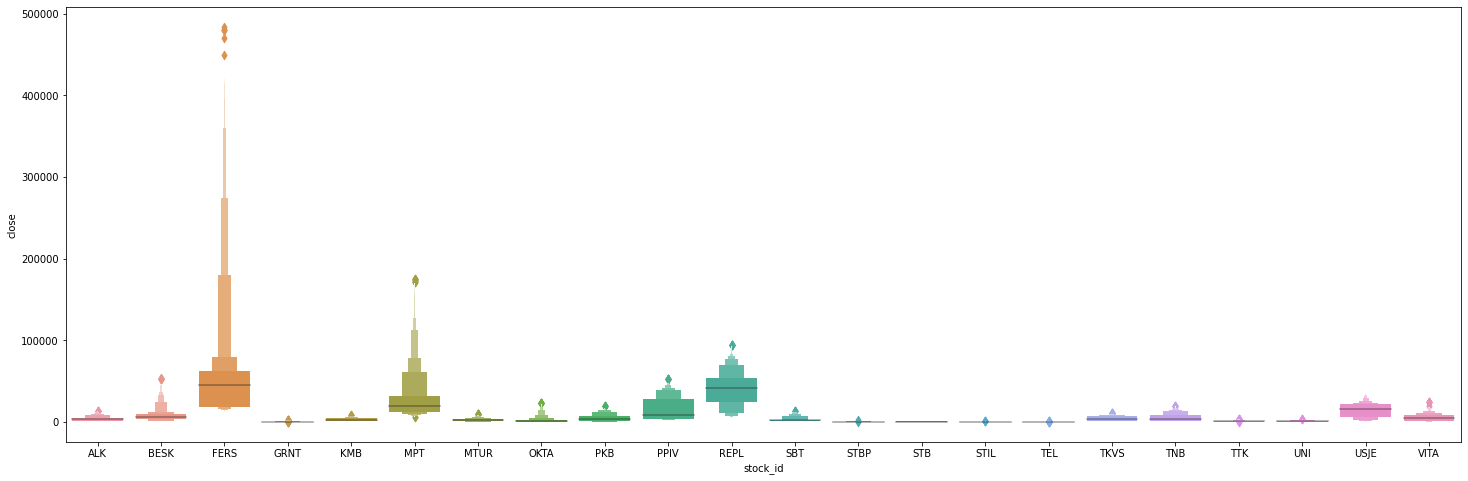

In [99]:
plt.figure(figsize=(25, 8))
sns.boxenplot('stock_id', df_sorted.close, data=df_final)
plt.show()

### rolling

In [101]:
df_final = df_final.set_index('date')

In [102]:
df_final.head(3)

,stock_id,open,high,low,average,close,volume,quantity,change %,volume total,...,sale_dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,days_in_month,is_leap_year,sales_elapsed
date,,,,,,,,,,,,,,,,,,,,,
1997-01-09,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,279270.0,261.0,0.0,279270.0,...,9,False,False,False,False,False,False,31,False,0
1997-01-10,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,...,10,False,False,False,False,False,False,31,False,1
1997-01-11,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,...,11,False,False,False,False,False,False,31,False,2


In [103]:
#rolloing for 7 days target
sum_7_qty_by_stock = []
volumne_moving_avg_7 = []
close_moving_avg_7 = []
close_volatility_7 = []
max_7_days = []
min_7_days = []
change_by_stock_daily_prev = []
profitability_daily_prev = []
ratio_prev = []

for stock in df_final.stock_id.unique():
    # sum quantity over last 7 days
    qty_sum = df_final[df_final.stock_id == stock].quantity.rolling(7).sum()
    sum_7_qty_by_stock.append(qty_sum)
    # moving average on volumne over last 7 days
    volumne_ma_7 = df_final[df_final.stock_id == stock].volume.rolling(7).mean()
    volumne_moving_avg_7.append(volumne_ma_7)
    # moving average on close price over last 7 days
    close_ma_7 = df_final[df_final.stock_id == stock].close.rolling(7).mean()
    close_moving_avg_7.append(close_ma_7)
    # volatility in close price over last 7 days
    close_volatility_7_by_stock = df_final[df_final.stock_id == stock].close.rolling(7).std().shift()
    close_volatility_7.append(close_volatility_7_by_stock)
    # max close price in last 7 days
    max_7_by_stock = df_final[df_final.stock_id == stock].close.rolling(7).max()
    max_7_days.append(max_7_by_stock)
    # min close price in last 7 days
    min_7_by_stock = df_final[df_final.stock_id == stock].close.rolling(7).min()
    min_7_days.append(min_7_by_stock)
    # ratio overall will be average price devided by max closing price over all time
    max_close_price = df_final[df_final.stock_id == stock].close.max()
    ratio_by_stock_prev = df_final[df_final.stock_id == stock].close.shift(1) / max_close_price
    ratio_prev.append(ratio_by_stock_prev)
    
    # daily_change new feature
    today = df_final[df_final.stock_id == stock].close.shift(1)
    yesterday = today.shift(2)
    change_by_stock =  today / yesterday - 1
    change_by_stock_daily_prev.append(change_by_stock)
    
    # daily_profitability_prev new feature
    profitability_by_stock_prev = df_final[df_final.stock_id == stock].close.shift(1) - df_final[df_final.stock_id == stock].open.shift(1)
    profitability_daily_prev.append(profitability_by_stock_prev)
    

In [104]:
chain_object_1 = itertools.chain.from_iterable(sum_7_qty_by_stock)
flattened_list_1 = list(chain_object_1)

chain_object_2 = itertools.chain.from_iterable(volumne_moving_avg_7)
flattened_list_2 = list(chain_object_2)

chain_object_3 = itertools.chain.from_iterable(close_moving_avg_7)
flattened_list_3 = list(chain_object_3)

chain_object_4 = itertools.chain.from_iterable(close_volatility_7)
flattened_list_4 = list(chain_object_4)

chain_object_5 = itertools.chain.from_iterable(max_7_days)
flattened_list_5 = list(chain_object_5)

chain_object_6 = itertools.chain.from_iterable(min_7_days)
flattened_list_6 = list(chain_object_6)

ratio_object = itertools.chain.from_iterable(ratio_prev)
flattened_list_7 = list(ratio_object)

change_daily_object = itertools.chain.from_iterable(change_by_stock_daily_prev)
flattened_list_8 = list(change_daily_object)

profitability_object = itertools.chain.from_iterable(profitability_daily_prev)
flattened_list_9 = list(profitability_object)

In [105]:
rolling_7_days = pd.DataFrame({'sum_7_qty_by_stock':flattened_list_1, 
                               'moving_avg_volume_7_days':flattened_list_2,
                               'moving_avg_close_7_days':flattened_list_3,
                               'volatility_7_days':flattened_list_4,
                               'max_7_days':flattened_list_5,
                               'min_7_days':flattened_list_6,
                               'ratio_overall_prev':flattened_list_7,
                               'change_daily_prev':flattened_list_8,
                               'profitability_daily_prev':flattened_list_9}
                             )

In [106]:
print(df_final.shape, rolling_7_days.shape)

(164754, 25) (164754, 9)


In [107]:
df_7_days = pd.concat([df_final.reset_index(), rolling_7_days], axis=1)

In [108]:
# Calculating ratios up to 7 days
df_7_days['ratio_7_days_prev'] = df_7_days.average.shift(1) / df_7_days.max_7_days

In [109]:
### Add column based on data analysis

# 1 day
df_7_days['prevopen_1'] = df_7_days.groupby(['stock_id'])['open'].shift(2)
#(open - prevopen) / prevopen
df_7_days['returnsOpenPrevRaw1'] = (df_7_days.open.shift(1) - df_7_days.prevopen_1) / df_7_days.prevopen_1

#10 days
df_7_days['prevopen_7'] = df_7_days.groupby(['stock_id'])['open'].shift(8)
df_7_days['returnsOpenPrevRaw_7'] = (df_7_days.open.shift(1) - df_7_days.prevopen_7) / df_7_days.prevopen_7

#Rate of change

# pct_chg = lambda x:x.pct_change()
# df_7_days['pct'] = df_7_days.groupby(['stock_id'])['close'].apply(pct_chg)

#Z-score
# zscore = lambda x:(x-x.mean())/x.std()
# df_7_days['z_score'] = df_7_days.groupby(['stock_id'])['close'].apply(zscore)

#percentile transformation
#rollrank = lambda x: x.rolling(200, min_periods=20).apply(lambda x:pd.Series(x).rank(pct=True)[0])
#df_7_days['percentile'] = df_7_days.groupby(['stock_id'])['volume'].apply(rollrank)

In [110]:
display_all(df_7_days.tail(25).T)

,164729,164730,164731,164732,164733,164734,164735,164736,164737,164738,164739,164740,164741,164742,164743,164744,164745,164746,164747,164748,164749,164750,164751,164752,164753
date,2020-08-01 00:00:00,2020-08-02 00:00:00,2020-08-03 00:00:00,2020-08-04 00:00:00,2020-08-05 00:00:00,2020-08-06 00:00:00,2020-08-07 00:00:00,2020-08-08 00:00:00,2020-08-09 00:00:00,2020-08-10 00:00:00,2020-08-11 00:00:00,2020-08-12 00:00:00,2020-08-13 00:00:00,2020-08-14 00:00:00,2020-08-15 00:00:00,2020-08-16 00:00:00,2020-08-17 00:00:00,2020-08-18 00:00:00,2020-08-19 00:00:00,2020-08-20 00:00:00,2020-08-21 00:00:00,2020-08-22 00:00:00,2020-08-23 00:00:00,2020-08-24 00:00:00,2020-08-25 00:00:00
stock_id,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA,VITA
open,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
high,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
low,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
average,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
close,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080,14080
volume,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
quantity,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
change %,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### XGBoost for ALK

In [111]:
df_alk = df_7_days[df_7_days.stock_id == 'ALK']

In [112]:
to_drop = ['date', 'stock_id', 'open', 'high', 'low', 'average', 'volume', 'quantity', 'change %', 'volume total']

In [113]:
df_alk.dropna()

,date,stock_id,open,high,low,average,close,volume,quantity,change %,...,max_7_days,min_7_days,ratio_overall_prev,change_daily_prev,profitability_daily_prev,ratio_7_days_prev,prevopen_1,returnsOpenPrevRaw1,prevopen_7,returnsOpenPrevRaw_7
8,1997-01-17,ALK,1030.0,1030.0,1030.0,1030.00,1030.0,0.0,0.0,0.00,...,1070.0,1030.0,0.072792,-0.019048,-20.0,0.962617,1050.0,0.000000,1070.0,-0.018692
9,1997-01-18,ALK,1030.0,1030.0,1030.0,1030.00,1030.0,0.0,0.0,0.00,...,1070.0,1030.0,0.072792,-0.019048,0.0,0.962617,1050.0,-0.019048,1070.0,-0.037383
10,1997-01-19,ALK,1030.0,1030.0,1030.0,1030.00,1030.0,0.0,0.0,0.00,...,1070.0,1030.0,0.072792,0.000000,0.0,0.962617,1030.0,0.000000,1070.0,-0.037383
11,1997-01-20,ALK,1030.0,1030.0,1030.0,1030.00,1030.0,0.0,0.0,0.00,...,1050.0,1030.0,0.072792,0.000000,0.0,0.980952,1030.0,0.000000,1070.0,-0.037383
12,1997-01-21,ALK,1030.0,1030.0,1010.0,1026.39,1010.0,62610.0,61.0,0.00,...,1050.0,1010.0,0.072792,0.000000,0.0,0.980952,1030.0,0.000000,1070.0,-0.037383
13,1997-01-22,ALK,1010.0,1010.0,1010.0,1010.00,1010.0,0.0,0.0,0.00,...,1030.0,1010.0,0.071378,-0.019417,-20.0,0.996495,1030.0,0.000000,1070.0,-0.037383
14,1997-01-23,ALK,1010.0,1010.0,1009.0,1009.83,1010.0,421100.0,417.0,2.00,...,1030.0,1010.0,0.071378,-0.019417,0.0,0.980583,1030.0,-0.019417,1050.0,-0.038095
15,1997-01-24,ALK,1010.0,1010.0,1010.0,1010.00,1010.0,0.0,0.0,0.00,...,1030.0,1010.0,0.071378,0.000000,0.0,0.980417,1010.0,0.000000,1050.0,-0.038095
16,1997-01-25,ALK,1010.0,1010.0,1010.0,1010.00,1010.0,0.0,0.0,0.00,...,1030.0,1010.0,0.071378,0.000000,0.0,0.980583,1010.0,0.000000,1030.0,-0.019417
17,1997-01-26,ALK,1010.0,1010.0,1010.0,1010.00,1010.0,0.0,0.0,0.00,...,1030.0,1010.0,0.071378,0.000000,0.0,0.980583,1010.0,0.000000,1030.0,-0.019417


In [114]:
df_alk.drop(to_drop, axis=1, inplace=True)

C:\Users\USER\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [121]:
df_alk.reset_index(inplace=True)

In [122]:
X, y = df_alk.drop('close', axis=1), df_alk.close

In [131]:
#test_size  = 0.02
#valid_size = 0.10

#test_split_idx  = int(df_alk.shape[0] * (1-test_size))
#valid_split_idx = int(df_alk.shape[0] * (1-(valid_size+test_size)))
def split_vals(dataset, n_test):
    n = dataset.shape[0] - n_test
    train_valid = dataset[:n].copy()
    return train_valid[:-n_test].copy(), train_valid[:n_test].copy(), dataset[-n_test:]

n_test = 7
X_train, X_valid, X_test = split_vals(X, n_test)
y_train, y_valid, y_test = split_vals(y, n_test)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

test_split_idx  = 7
valid_split_idx = 7

train_df  = df_alk.loc[:df_alk.shape[0]-test_split_idx].copy()
valid_df  = df_alk.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df_alk.loc[df_alk.shape[0]-test_split_idx+1:].copy()


In [132]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.index, y=train_df.close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.index, y=valid_df.close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.index,  y=test_df.close,  name='Test'))
fig.show()

#### Drop unnecessary columns

In [133]:
df_alk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8630 entries, 0 to 8629
Data columns (total 31 columns):
index                       8630 non-null int64
close                       8630 non-null float64
sale_year                   8630 non-null int64
sale_month                  8630 non-null int64
sale_week                   8630 non-null int64
sale_day                    8630 non-null int64
sale_dayofweek              8630 non-null int64
sale_dayofyear              8630 non-null int64
is_month_end                8630 non-null bool
is_month_start              8630 non-null bool
is_quarter_end              8630 non-null bool
is_quarter_start            8630 non-null bool
is_year_end                 8630 non-null bool
is_year_start               8630 non-null bool
days_in_month               8630 non-null int64
is_leap_year                8630 non-null bool
sales_elapsed               8630 non-null int64
sum_7_qty_by_stock          8624 non-null float64
moving_avg_volume_7_days    8624

In [136]:
import math

def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), 
           rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train),
           m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

#### Fine-tune XGBoostRegressor

In [137]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.02],
              #, 0.005, 0.01, 0.02],
    'random_state': [42]
}


eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.02, 'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 400, 'random_state': 42}
Best validation score = 0.9405692432661388
Wall time: 1h 10min


In [138]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

Wall time: 27.4 s


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.02, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

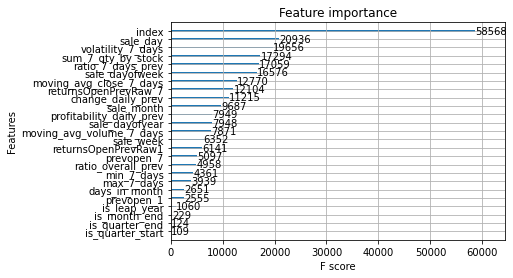

In [139]:
plot_importance(model)

#### Calculate and visualize predictions

In [140]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [12300. 12223. 12290. 12290. 12290.]
y_pred = [12337.556 12375.449 12319.351 12399.886 12321.933]


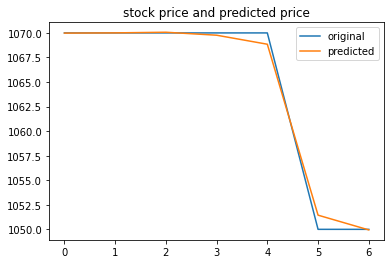

In [148]:
x_ax = range(len(y_valid))
plt.plot(x_ax, y_valid, label="original")
plt.plot(x_ax, model.predict(X_valid), label="predicted")
plt.title("stock price and predicted price")
plt.legend()
plt.show()

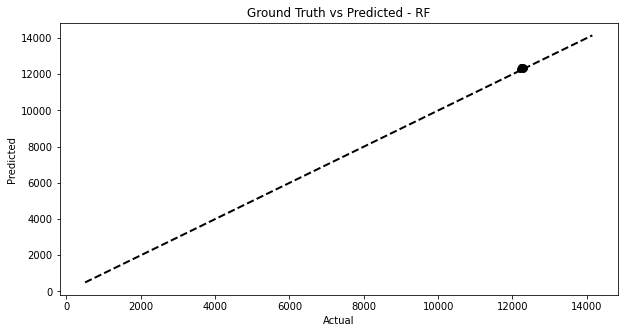

In [149]:
plt.figure(figsize=(10,5))

plt.scatter(y_test, y_pred, color='black')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.title('Ground Truth vs Predicted - RF')
plt.xlabel(xlabel='Actual')
plt.ylabel(ylabel='Predicted')
plt.show()